## Structural Model
$X_1 \sim Ber(.3)$

$X_2 \sim \mathcal{N}(X_1,.1)$

$X_3 = X_2 ^2$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.random.seed(40997)

def f1():
    return np.random.binomial(1, 0.3)

def f2(x1):
    return np.random.normal(loc=x1, scale=.1)

def f3(x2):
    return x2 ** 2

x1 = f1()
x2 = f2(x1)
x3 = f3(x2)

print("x1:{}, x2:{:.3f}, x3:{:.3f}".format(x1,x2,x3))

x1:0, x2:0.012, x3:0.000


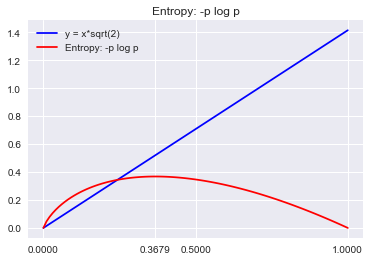

In [2]:
#
# Plot Entropy = - p log p
#
# 0 to sqrt(2) so the entire area under the Prob curve is 1
x = np.linspace(1e-10,1,100)
y1 = np.sqrt(2) * x
y2 = -x * np.log(x)
plt.plot(x, y1, 'b', label='y = x*sqrt(2)')
plt.plot(x, y2, 'r', label='Entropy: -p log p')
plt.title('Entropy: -p log p')
plt.xticks([np.min(x), np.exp(-1), np.average(x), np.max(x)]) #max at 1/e
plt.legend()

## Causal Graphical Models
pip install causalgraphicalmodels

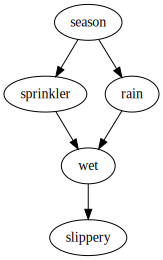

In [3]:
from causalgraphicalmodels import CausalGraphicalModel
sprinkler = CausalGraphicalModel(
    nodes=['season','rain',  'sprinkler', 'wet', 'slippery'],
    edges=[
        ('season', 'rain'),
        ('season', 'sprinkler'),
        ('rain', 'wet'),
        ('sprinkler', 'wet'),
        ('wet', 'slippery')
    ]
)
sprinkler.draw()


In [4]:
print(sprinkler.get_distribution())

P(season)P(rain|season)P(sprinkler|season)P(wet|rain,sprinkler)P(slippery|wet)


P(season)P(sprinkler|season)P(wet|do(rain),sprinkler)P(slippery|wet)


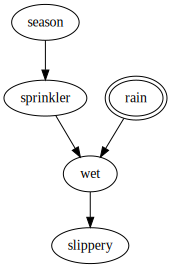

In [5]:
sprinkler_do = sprinkler.do('rain')
print(sprinkler_do.get_distribution())
sprinkler_do.draw()

### Causal Inference with Causal Graphical Models
Can we make inferences from observational data? Consider, the following confounder setup where $Z$

confounds the relationship between $X$ and $Y$. If we intervene on $X$, then we get the DAG

farther below and then that decouples $Z$ and $X$.

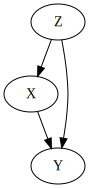

In [6]:
confounder = CausalGraphicalModel(
    nodes=['X','Y','Z'],
    edges=[
        ('X', 'Y'),
        ('Z', 'Y'),
        ('Z', 'X'),
    ]
)
confounder.draw()

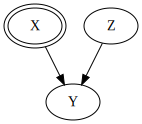

In [7]:
confounder_do = confounder.do('X')
confounder_do.draw()

In [8]:
%%latex

\begin{align}
P(Y|do(X)) &= \sum_Z P(Y|do(X),Z)P(Z|do(X))  ~~~~~~ \text{axioms of prob} \\
    &= \sum_Z P(Y|do(X),Z)P(Z) ~~~~~~ \text{$Z$ is independent of $do(X)$} \\
    &= \sum_Z P(Y|X, Z)P(Z) ~~~~~~ \text{stability assumption, that $Y$ behaves the same given its parents} \\
    \\
P(Y|do(X)) &= \sum_Z P(Y|X, Z)P(Z) ~~~~~~ \textbf{Adjustment Formula / g-formula}\\
\end{align}
Compare the above to the conditional on the observed data

$P(Y|X) = \sum_Z P(Y|X, Z)P(Z|X) $



<IPython.core.display.Latex object>

## Adjustment Formula
When is the adjustment formula true? It is true only when the following apply:
    
$Z$ blocks all backdoor paths between $X$ and $Y$

$Z$ does not contain any descendants of $X$

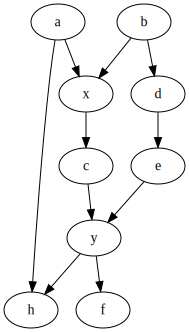

In [9]:
from causalgraphicalmodels.examples import big_csm
example_cgm = big_csm.cgm
example_cgm.draw()

In [10]:
# get all backdoor adjustment sets
example_cgm.get_all_backdoor_adjustment_sets('x','y')

frozenset({frozenset({'d', 'e'}),
           frozenset({'a', 'e'}),
           frozenset({'a', 'd', 'e'}),
           frozenset({'b'}),
           frozenset({'b', 'd'}),
           frozenset({'a', 'b'}),
           frozenset({'d'}),
           frozenset({'a', 'd'}),
           frozenset({'a', 'b', 'd'}),
           frozenset({'e'}),
           frozenset({'b', 'e'}),
           frozenset({'a', 'b', 'e'}),
           frozenset({'b', 'd', 'e'}),
           frozenset({'a', 'b', 'd', 'e'})})

In [11]:
big_csm.sample(5)

,b,d,e,a,x,c,y,f,h
0,-0.779979,0.592671,2.108259,-0.211792,0,-0.234952,-3.149868,-1.834548,-4.576666
1,-1.058772,1.024925,0.622312,-0.221537,0,0.057270,0.867680,-0.026985,0.124077
2,-0.110376,-0.042870,-0.455473,-0.115910,0,-0.820117,-2.491658,-1.045292,-4.123815
3,-0.630953,-0.198309,-0.737376,-1.339891,0,-0.168683,1.148839,1.531666,-0.113968
4,-0.532262,0.367744,2.193800,-1.814282,1,1.729301,3.186595,3.141783,0.772651


In [19]:
# Estimate ATE from this observational data
from causalinference import CausalModel
def estimate_ate(dataset, adjustment_set=None, method='matching'):
    if adjustment_set is None:
        y0 = dataset.loc[lambda df: df.x==0].y.mean()
        y1 = dataset.loc[lambda df: df.x==1].y.mean()
        
        y0_var = dataset.loc[lambda df: df.x==0].y.var()
        y1_var = dataset.loc[lambda df: df.x==1].y.var()
        
        n_y0 = dataset.loc[lambda df: df.x==0].shape[0]
        n_y1 = dataset.loc[lambda df: df.x==1].shape[0]
        return {
            'ate': y1 - y0,
            'ate_se': 2 * np.sqrt(y1_var/n_y1 + y0_var/n_y0)
        }
    
    cm = CausalModel(
        Y=dataset.y.values, #outcome
        D=dataset.x.values, #treatment
        X=dataset[adjustment_set].values #confounders
    )
    cm.est_via_ols()
    cm.est_via_matching()
    
    cm.est_propensity_s()
    cm.est_via_weighting()
    
    cm.stratify_s()
    cm.est_via_blocking()
    
    return {
        'ate': cm.estimates[method]['ate'],
        'ate_se': cm.estimates[method]['ate_se']
    }
    

In [20]:
estimate_ate(big_csm.sample(10000)) # not real ATE because it is observational

{'ate': 4.484538064771581, 'ate_se': 0.17055645606035957}

In [21]:
nsamples = 10000
ds = big_csm.sample(nsamples)
#
# Generate samples from interventional distribution
# Values of X are assigned randomly as in A/B test
#
ds_intervention = (
    big_csm.do('x')
    .sample(
        10000, 
        set_values={'x': np.random.binomial(n=1, size=10000, p=0.5)}
    )
)
true_ate = estimate_ate(ds_intervention)
print(true_ate)

#
# Generate results for a few different adjustment sets
#
results = {
    'no_adjustment': estimate_ate(ds),
    'adjustment_b': estimate_ate(ds, ['b']),
    'adjustment_bde': estimate_ate(ds, ['b','d','e']),
    'adjustment_bh': estimate_ate(ds, ['b', 'h']),
    'adjustment_bc': estimate_ate(ds, ['b','c']),
    'adjustment_all': estimate_ate(ds, ['a','b','c','d','e','f','h']),
}
print(results)

{'ate': 2.9813784652161837, 'ate_se': 0.17391798378482043}
{'no_adjustment': {'ate': 4.459599599419482, 'ate_se': 0.17303193947682885}, 'adjustment_b': {'ate': 2.8848192161447574, 'ate_se': 0.14373454279146847}, 'adjustment_bde': {'ate': 2.9963612366576262, 'ate_se': 0.10917635552681271}, 'adjustment_bh': {'ate': 1.5821370929380225, 'ate_se': 0.056654666704890423}, 'adjustment_bc': {'ate': -0.045882294748157797, 'ate_se': 0.10655645525591194}, 'adjustment_all': {'ate': 0.17598153754726498, 'ate_se': 0.038851708994256287}}


[0 1 2 3 4 5] [4.459599599419482, 2.8848192161447574, 2.9963612366576262, 1.5821370929380225, -0.045882294748157797, 0.17598153754726498] [0.17303193947682885, 0.14373454279146847, 0.10917635552681271, 0.056654666704890423, 0.10655645525591194, 0.038851708994256287]


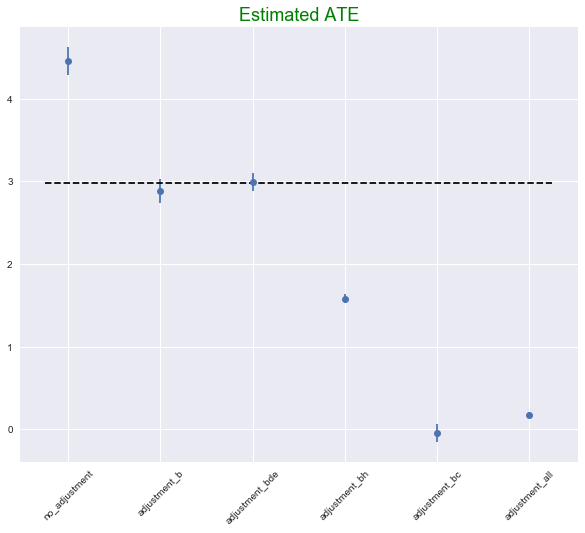

In [27]:
x_label = list(results.keys())
x = np.arange(len(x_label))
y, yerr = [], []
for l in x_label:
    if results[l] is not None:
        y += results[l]['ate'],
        yerr += results[l]['ate_se'],

print(x,y,yerr)
plt.figure(figsize=(10,8))
plt.errorbar(x=x,y=y,yerr=yerr, linestyle='none', capsize=5, marker='o')
plt.xticks(x, x_label, rotation=45,fontsize=10)
plt.title('Estimated ATE', color='g', fontsize=18)
xmin, xmax = plt.xlim()
plt.hlines(true_ate['ate'], xmin, xmax, linestyle='dashed')